## CNN(PyTorch) - MNIST Denoising Autoencoder

- Denoising images
- For that lets get some data with some noise on the MNIST images
- Then we will train an auto encoder to de-noise the images

Steps to perform Autoencoder
- Input data is passed through an encoder 
- Encoder will compress the input
- Compressed data is is passed through a decoder to reconstruct the input data

### Importing libraries and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

### Loading data

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

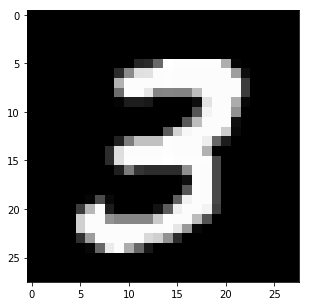

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[7])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.show()

### Creating Convolutional Autoencoder model

Steps to perform Autoencoder
- Input data is passed through an encoder
    - Input images are 28x28x1 in size. these images will be passed through encoder layers
- Encoder will compress the input
    - It will have convolutional layers followed by max pooling layer to reduce dimensions to 7x7x4
- Compressed data is is passed through a decoder to reconstruct the input data
    - This layer will bring back to original dimension 28x28x1
    - Will use a combination of nearest-neighbor upsampling and normal convolutional layers to increase the width and height of the input layers.
    - In this Distill article from Augustus Odena, et al, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.

Note: The images from this dataset are already normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class DeNoiser(nn.Module):
    def __init__(self):
        super(DeNoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = DeNoiser()
print(model)

DeNoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### Training

- We need to add some noise to the MNIST images first and then we will feed these images to our model
- With Autoencodes we dont need to check for labels because we will be comparing the original input to decoded output
- Because we are comparing pixel values in input and output images, we will use loss function for regession task. We will use MSELoss

In [5]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# for adding noise to images
noise_factor=0.5
epochs = 20
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images, _ = data                        # we are just intrested in images
        # no need to flatten images
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()                   # clear the gradients
        outputs = model(noisy_imgs)             # forward pass: compute predicted outputs 
        loss = criterion(outputs, images)       # calculate the loss
        loss.backward()                         # backward pass
        optimizer.step()                        # perform optimization step
        train_loss += loss.item()*images.size(0)# update running training loss
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
          '\tTraining Loss: {:.4f}'.format(train_loss))

C:\Users\HOME\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.8251
Epoch: 2 	Training Loss: 0.5364
Epoch: 3 	Training Loss: 0.4712
Epoch: 4 	Training Loss: 0.4391
Epoch: 5 	Training Loss: 0.4209
Epoch: 6 	Training Loss: 0.4088
Epoch: 7 	Training Loss: 0.3990
Epoch: 8 	Training Loss: 0.3921
Epoch: 9 	Training Loss: 0.3859
Epoch: 10 	Training Loss: 0.3819
Epoch: 11 	Training Loss: 0.3778
Epoch: 12 	Training Loss: 0.3745
Epoch: 13 	Training Loss: 0.3723
Epoch: 14 	Training Loss: 0.3687
Epoch: 15 	Training Loss: 0.3664
Epoch: 16 	Training Loss: 0.3629
Epoch: 17 	Training Loss: 0.3600
Epoch: 18 	Training Loss: 0.3587
Epoch: 19 	Training Loss: 0.3570
Epoch: 20 	Training Loss: 0.3561


### Comparing inputs before encoding and output after decoding

Below we can notice that ouput edges are not smooth like in inputs. This is due to checkerboard effect that will happen with transpose layers 

C:\Users\HOME\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


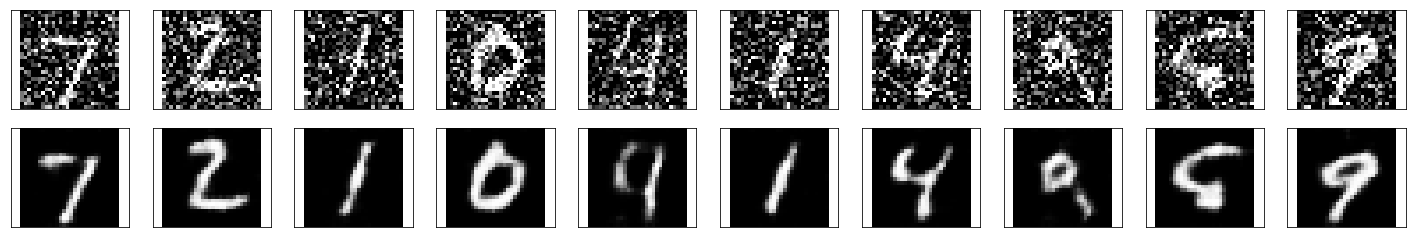

In [7]:
# Lets get batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)                 # get sample outputs
noisy_imgs = noisy_imgs.numpy()            # prep images for display
output = output.view(batch_size, 1, 28, 28)# resizing output
output = output.detach().numpy()           # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)